In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
image = cv2.imread('test_image.png')
#import image as array np

In [3]:
cv2.imshow('test image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

13

In [3]:
lane_image = np.copy(image) #creiamo una copia così da non influenzare l'immagine originale
#per usare l'edge detector l'immagine deve essere in gray scale
gray = cv2.cvtColor(lane_image, cv2.COLOR_RGB2GRAY)
cv2.imshow('gray', gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [15]:
#prima di fare l'edge, dobbiamo eliminare il ruomore con una Gaussian Blur
blur = cv2.GaussianBlur(gray, (5,5), 0)
cv2.imshow('blur', blur)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [16]:
canny = cv2.Canny(blur, 50, 150)
cv2.imshow('Canny', canny)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [2]:
def toCanny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5),0)
    canny = cv2.Canny(blur, 70, 150)
    return canny

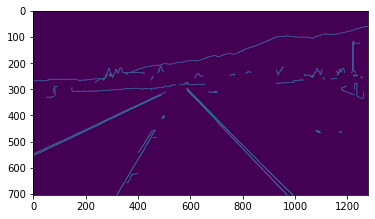

In [24]:
canny = toCanny(image)
plt.imshow(canny)
plt.show()

Andiamo a definire la regione di interesse, in questo caso un triangolo <img src = 'roi.png'></img>

In [3]:
def region_of_interest(image):
    height = image.shape[0]
    triangle = np.array([
        [(200, height), (1100, height), (550, 250)]
    ])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, triangle, 255) #crea maschera
    return mask

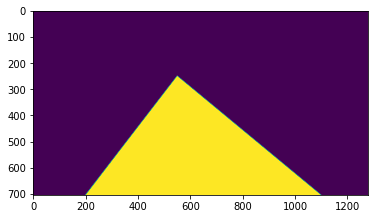

In [32]:
plt.imshow(region_of_interest(canny))
plt.show()

Ora facciamo l'operazione AND bit a bit: ogni cella dell'immagine si confronterà con la cella del filtro e passeranno solo i bit con entrambi 1. Il nostro filtro è fatto da zeri fuori dal triangolo e solo 1 dentro il triangolo. Quindi l'effetto sarà quello di "oscurare" la parte fuori dal triangolo.

In [4]:
def region_of_interest(image):
    height = image.shape[0]
    triangle = np.array([
        [(200, height), (1100, height), (550, 250)]
    ])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, triangle, 255) #crea maschera
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

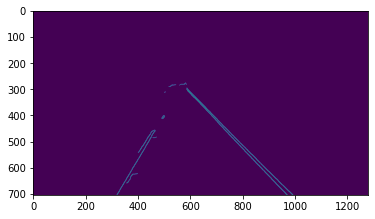

In [34]:
cropped_image = region_of_interest(canny)
plt.imshow(cropped_image)
plt.show()

In [5]:
def display_lines(image, lines):
    line_image = np.zeros_like(image) #black image
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    
    return line_image    

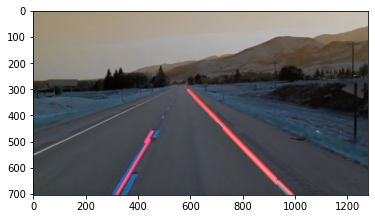

In [40]:
lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]),minLineLength = 40, maxLineGap = 5)
line_image = display_lines(lane_image, lines)
combo_image = cv2.addWeighted(lane_image, 0.8, line_image, 1, 1)
plt.imshow(combo_image)
plt.show()

In [6]:
def average_slope_intercept(image, lines):
    left_fit = []  #linee sulla sinistra
    right_fit = [] #linee sulla destra
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1) #Returns a vector of coefficients p that minimises the squared error 
        slope = parameters[0] #pendenza
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
    
    left_fit_average = np.average(left_fit, axis = 0)
    right_fit_average = np.average(right_fit, axis = 0)
    
    left_line = make_coordinates(image, left_fit_average)
    right_line = make_coordinates(image, right_fit_average)
    
    return np.array([left_line, right_line])

In [7]:
def make_coordinates(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*3/5) #roi
    # x = (y -b)/m
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    
    return np.array([x1, y1, x2, y2])   

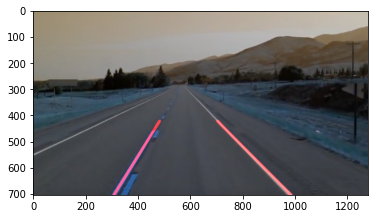

In [53]:
avereged_lines = average_slope_intercept(lane_image, lines)
line_image = display_lines(lane_image, avereged_lines)
combo_image = cv2.addWeighted(lane_image, 0.8, line_image, 1, 1)
plt.imshow(combo_image)
plt.show()

In [ ]:
cap = cv2.VideoCapture("test2.mp4") #usa 0 all'interno per vedere in diretta
while cap.isOpened():
    _, frame = cap.read()
    image = np.array(frame)
    canny = toCanny(image)
    cropped = region_of_interest(canny)
    lines = cv2.HoughLinesP(cropped, 2, np.pi/180, 100, np.array([]),minLineLength = 40, maxLineGap = 5)
    avereged_lines = average_slope_intercept(image, lines)
    line_image = display_lines(image, avereged_lines)
    combo_image = cv2.addWeighted(image, 0.8, line_image, 1, 1)
    cv2.imshow("Line image", combo_image)
    key = cv2.waitKey(1) & 0xFF
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break